In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [11]:
from pinns.prelude import *
from pinns.domain import Sphere
from pinns.krr import krr, rbf
from pinns.pde import poisson_dirichlet_qp_mc
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [18]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


In [32]:
def mag(x):
    return array([0., 0., 1.])


def phi2_solution(x, x_bnd, phi1):
    eps = 1e-7
    def g(y):
        n = y / norm(y, axis=-1)
        return dot(mag(y), n) - dot(grad(phi1)(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)



def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("ELM")    
    plot_result(lambda x: abs(model(x) - x[..., 2] / 3), ax2)
    ax2.set_title("Absolute error")


In [33]:
from pinns.calc import divergence
#ELM
weights = array(Sobol(4, seed=12345).random_base2(6))
W = weights[:, :3] * 2 - 1
b = weights[:, 3] * 2 - 1
l = lambda x: (1 - norm(x, axis=-1) ** 2)
u = lambda x: l(x) * tanh(W @ x + b)

f = lambda x: -divergence(mag)(x)

phi1 = poisson_dirichlet_qp_mc(u, lambda x: 0., x_dom, f)

In [34]:
_x_bnd = array(Sobol(2, seed=123).random_base2(15))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd, phi1)

In [35]:
from pinns.elm import elm
g = elm(x_bnd, phi_bnd, W, b)
phi2 = poisson_dirichlet_qp_mc(u,g, x_dom, lambda x: 0.
     #refine_regularization=5, refine_maxiter=20, tol=1e-7, maxiter=2000
)
model = lambda x: phi1(x) + phi2(x)

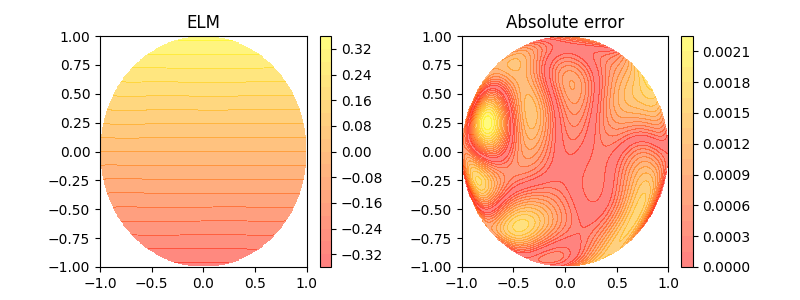

In [36]:
plot_model(vmap(model))

In [15]:
from pinns.elm import elm

In [17]:
weights = array(Sobol(4, seed=12345).random_base2(4))
W = weights[:, :3] * 2 - 1
b = weights[:, 3] * 2 - 1
g = elm(x_bnd, phi_bnd, W, b)
l = lambda x: (1 - norm(x, axis=-1) ** 2)
u = lambda x: l(x) * tanh(W @ x + b)

X = concatenate([x_bnd, x_dom])
_model = poisson_dirichlet_qp_mc(u, g, x_dom, lambda x: 0, tol=1e-7)
model = vmap(_model)

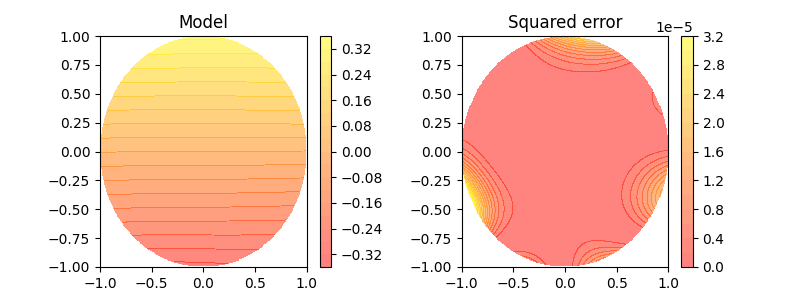

In [18]:
plot_model(model)